   # Introduction aux réseaux de neurones
                           Valentyn Gerushta, Léane Salais
   


In [ ]:
!wget http://webia.lip6.fr/~dancette/deep-learning/assets/TP3-4/TP3-4.zip
!unzip -j TP3-4.zip

In [ ]:
import math
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%run 'tme5.py'

# Partie 1 : Forward et backward manuels

Initialisation des paramètres, passe forward, calcul de la loss et de la précision, rétropropagation et mise à jour des paramètres dans des fonctions séparées.

In [ ]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}
    #####################
    ## Votre code ici  ##
    #####################
    params['Wh'] = torch.randn(nh,nx) * 0.3
    params['Wy'] = torch.randn(ny,nh) * 0.3
    params['bh'] = torch.zeros(nh,1)
    params['by'] = torch.zeros(ny,1)
    ####################
    ##      FIN        #
    ####################
    return params

In [ ]:
def forward(params, X):
    """
    params: dictionary
    X: (n_batch, dimension)
    """ 
    bsize = X.size(0)
    nh = params['Wh'].size(0)
    ny = params['Wy'].size(0)
    outputs = {}
    ####################
    #  Votre code ici  #
    ####################
    outputs['X'] = X
    outputs['htilde'] = torch.mm(X, params['Wh'].t()) + params['bh'].t().expand(bsize,nh)
    outputs['h'] = torch.tanh(outputs['htilde'])
    outputs['ytilde'] = torch.mm(outputs['h'],params['Wy'].t()) + params['by'].t().expand(bsize,ny)
    outputs['ytilde'] = torch.exp(outputs['ytilde'])
    outputs['yhat'] = outputs['ytilde']/(outputs['ytilde'].sum(1,keepdim=True)).expand_as(outputs['ytilde'])
    ####################
    ##      FIN        #
    ####################
    return outputs['yhat'], outputs

In [ ]:
def loss_accuracy(Yhat, Y):
    #####################
    ## Votre code ici  ##
    #####################
    # cross-entropy loss
    L = -torch.mean(Y*torch.log(Yhat))
    # accuracy
    _, indsY = torch.max(Y,1)
    _, indsYhat = torch.max(Yhat,1)
    acc = torch.sum((indsY == indsYhat)) / indsY.size(0)
    ####################
    ##      FIN        #
    ####################
    return L, acc

In [ ]:
def backward(params, outputs, Y):
    bsize = Y.shape[0]
    grads = {}
    #####################
    ## Votre code ici  ##
    #####################
    deltay = outputs['yhat'] - Y
    grads['Wy'] = torch.mm(deltay.t(),outputs['h'])
    grads['by'] = deltay.sum(0,keepdim=True).t()
    deltah = torch.mm(deltay,params['Wy']) * (1-torch.pow(outputs['h'],2))
    grads['Wh'] = torch.mm(deltah.t(),outputs['X'])
    grads['bh'] = deltah.sum(0,keepdim=True).t()

    grads['Wy'] /= bsize
    grads['by'] /= bsize
    grads['Wh'] /= bsize
    grads['bh'] /= bsize
    ####################
    ##      FIN        #
    ####################
    return grads

In [ ]:
def sgd(params, grads, eta):
    #####################
    ## Votre code ici  ##
    #####################
    params['Wh'] -= eta * grads['Wh']
    params['Wy'] -= eta * grads['Wy']
    params['bh'] -= eta * grads['bh']
    params['by'] -= eta * grads['by']
    ####################
    ##      FIN        #
    ####################
    return params

In [ ]:
# Test des dimentions pour debug
# (utilisation de lignes assert pendant le développement)
data = CirclesData()
N = data.Xtrain.shape[0]
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
params = init_params(nx,nh,ny)
Yhat, outputs = forward(params, data.Xtrain)
print("Wh",params["Wh"].size())
print("Wy",params["Wy"].size())
print("X",outputs["X"].size())
print("htilde",outputs["htilde"].size())
print("h",outputs["h"].size())
print("ytilde",outputs["ytilde"].size())
print("yhat",outputs["yhat"].size())

Wh torch.Size([10, 2])
Wy torch.Size([2, 10])
X torch.Size([200, 2])
htilde torch.Size([200, 10])
h torch.Size([200, 10])
ytilde torch.Size([200, 2])
yhat torch.Size([200, 2])


## Algorithme global d'apprentissage (manuel)

Combinaison des fonctions précédentes et utilisation sur plusieurs itérations.

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.05

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(151):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Votre code ici  ##
    #####################
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]
        Yhat, outputs = forward(params, X)
        L,_ = loss_accuracy(Yhat, Y)
        grads = backward(params, outputs, Y)
        params = sgd(params,grads,eta)
    ####################
    ##      FIN        #
    ####################

    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)  

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain*100, Ltrain, acctest*100, Ltest)
    data.plot_data_with_grid(Ygrid, title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Partie 2 : Simplification du backward avec `torch.autograd`

Il faut modifier la déclaration des paramètres pour qu'ils soient automatiquement pris en charge par le backward() de PyTorch.

In [ ]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}
    #####################
    ## Votre code ici  ##
    #####################
    params["Wh"] = torch.randn(nh,nx) * 0.3
    params["Wh"].requires_grad_(True) # Activation de l'Autograd
    params['Wy'] = torch.randn(ny,nh) * 0.3
    params["Wy"].requires_grad_(True)
    params['bh'] = torch.zeros(nh,1)
    params["bh"].requires_grad_(True)
    params['by'] = torch.zeros(ny,1)
    params["by"].requires_grad_(True)
    ####################
    ##      FIN        #
    ####################
    return params

La fonction `forward` est inchangée par rapport à la partie précédente. 

La fonction `backward` n'est plus utilisée grâce à l'autograd. 

In [ ]:
def sgd(params, eta):
    #####################
    ## Votre code ici  ##
    #####################
    # ne surtout pas retenir le gradient ici
    with torch.no_grad():
      params["Wh"] -= eta * params["Wh"].grad
      params["Wy"] -= eta * params["Wy"].grad
      params["bh"] -= eta * params["bh"].grad
      params["by"] -= eta * params["by"].grad
      # remise à zéro des gradients 
      params["Wh"].grad.zero_()
      params["Wy"].grad.zero_()
      params["bh"].grad.zero_()
      params["by"].grad.zero_()   
    ####################
    ##      FIN        #
    ####################
    return params

## Algorithme global d'apprentissage (avec autograd)

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.1

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(151):

    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]
    #####################
    ## Votre code ici  ##
    #####################
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]
        Yhat, outputs = forward(params,X)
        loss,_ = loss_accuracy(Yhat,Y)
        loss.backward()
        params = sgd(params,eta)
    ####################
    ##      FIN        #
    ####################
    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)  

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain*100, Ltrain, acctest*100, Ltest)
    # detach() est utilisé pour détacher les predictions du graphes de calcul autograd
    data.plot_data_with_grid(Ygrid.detach(), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Partie 3 : Simplification du forward avec `torch.nn`

On déclare des couches de transformation linéaire au lieu de coder soi-même les transformations.

`init_params` et `forward` sont supprimés et remplacés par une fonction `init_model` qui déclare l'architecture du modèle et la loss.

In [ ]:
def init_model(nx, nh, ny):
    #####################
    ## Votre code ici  ##
    #####################
    model = torch.nn.Sequential(torch.nn.Linear(nx,nh),torch.nn.Tanh(),torch.nn.Linear(nh,ny))
    loss = torch.nn.CrossEntropyLoss()
    ####################
    ##      FIN        #
    ####################
    return model, loss

In [ ]:
def loss_accuracy(loss, Yhat, Y):
    #####################
    ## Votre code ici  ##
    #####################
    # fonction de loss prédéfinie
    _, indsY = torch.max(Y,1)
    _, indsYhat = torch.max(Yhat,1)
    L = loss(Yhat,indsY) 
    # accuracy
    acc = torch.sum((indsY == indsYhat)) / indsY.size(0)
    ####################
    ##      FIN        #
    ####################
    return L, acc

In [ ]:
def sgd(model, eta):
    #####################
    ## Votre code ici  ##
    #####################
    with torch.no_grad():
      # mise à jour de tous les paramètres 
      # sans rétention du gradient 
      for p in model.parameters():
        newp = p - eta * p.grad
        p.copy_(newp)
        p.grad.zero_()
    ####################
    ##      FIN        #
    ####################
    return model

## Algorithme global d'apprentissage (avec autograd et les couches `torch.nn`)

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.1

model, loss = init_model(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(151):
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]
    #####################
    ## Votre code ici  ##
    #####################
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]
        Yhat = model(X)
        l,_ = loss_accuracy(loss,Yhat,Y)
        l.backward()
        params = sgd(model,eta)
    ####################
    ##      FIN        #
    ####################
    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)
    Ygrid = torch.nn.Softmax(dim=1)(Ygrid)  

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain*100, Ltrain, acctest*100, Ltest)
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Partie 4 : Simplification de SGD avec `torch.optim`

Utilisation d'un optimiseur, plus de mise à jour manuelle des paramètres.  
A ce stade, avec Autograd, torch.nn et torch.optim, l'automatisation est complète.

In [ ]:
def init_model(nx, nh, ny, eta):
    #####################
    ## Votre code ici  ##
    #####################
    model = torch.nn.Sequential(torch.nn.Linear(nx,nh),torch.nn.Tanh(),torch.nn.Linear(nh,ny))
    loss = torch.nn.CrossEntropyLoss()
    optim = torch.optim.SGD(params=model.parameters(),lr=eta)
    ####################
    ##      FIN        #
    ####################
    return model, loss, optim

La fonction `sgd` est supprimée. À la place, on fera un appel à `optim.zero_grad()` avant de faire le backward et à `optim.step()` après le backward. 

## Algorithme global d'apprentissage (avec autograd, les couches `torch.nn` et `torch.optim`)

In [ ]:
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.001

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[],[], [], []]

for iteration in range(600):
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]
    #####################
    ## Votre code ici  ##
    #####################
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]
        fwd = model(X)
        l,_ = loss_accuracy(loss,fwd,Y)
        optim.zero_grad()
        l.backward()
        optim.step()
    ####################
    ##      FIN        #
    ####################
    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)
    
    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain*100, Ltrain, acctest*100, Ltest)
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Partie 5 : MNIST

Application du petit réseau de neurones à des données image pour la reconnaissance de chiffres.  
On considère chaque image comme un vecteur de données numériques (à une seule dimension). On ne s'intéresse pas à la localisation des pixels *dans l'espace* (features positionnelles x et y), mais seulement à la succession des valeurs dans les vecteurs de données.  
En fait, c'est déjà informatif :

Reprendre le code d'entraînement précédent en l'appliquant au dataset MNIST.

In [ ]:
# init
data = MNISTData()
N = data.Xtrain.shape[0]
Nbatch = 100
nx = data.Xtrain.shape[1]
nh = 100
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[],[], [], []]

for iteration in range(150):
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]
    #####################
    ## Votre code ici  ##
    #####################
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]
        fwd = model(X)
        l,_ = loss_accuracy(loss,fwd,Y)
        optim.zero_grad()
        l.backward()
        optim.step()
    ####################
    ##      FIN        #
    ####################
    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)

    if iteration%10==0:
      print('Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain*100, Ltrain, acctest*100, Ltest))

Iter 0: Acc train 86.0% (0.50), acc test 86.6% (0.49)
Iter 10: Acc train 89.2% (0.36), acc test 89.1% (0.35)
Iter 20: Acc train 89.6% (0.34), acc test 89.7% (0.33)
Iter 30: Acc train 91.1% (0.29), acc test 91.0% (0.29)
Iter 40: Acc train 91.2% (0.28), acc test 91.7% (0.28)
Iter 50: Acc train 92.2% (0.26), acc test 92.2% (0.26)
Iter 60: Acc train 92.8% (0.24), acc test 92.7% (0.23)
Iter 70: Acc train 91.7% (0.27), acc test 91.8% (0.27)
Iter 80: Acc train 93.1% (0.23), acc test 93.2% (0.22)
Iter 90: Acc train 93.3% (0.22), acc test 93.4% (0.22)
Iter 100: Acc train 93.1% (0.23), acc test 93.0% (0.23)
Iter 110: Acc train 93.2% (0.22), acc test 92.9% (0.24)
Iter 120: Acc train 92.9% (0.23), acc test 93.0% (0.23)
Iter 130: Acc train 93.6% (0.21), acc test 93.4% (0.23)
Iter 140: Acc train 93.3% (0.22), acc test 93.0% (0.23)


# Partie 6 : Bonus SVM


Usage d'un modèle SVM sur le jeu de data Circles.
- Essayer d'abord un SVM linéaire (sklearn.svm.LinearSVC dans scikit-learn).
- Essayer d'autres kernels (possible avec sklearn.svm.SVC).
- Faire varier le paramètre de régularisation C.

In [24]:
data = CirclesData()
Xtrain = data.Xtrain.numpy()
Ytrain = data.Ytrain[:, 0].numpy()
Xgrid = data.Xgrid.numpy()
Xtest = data.Xtest.numpy()
Ytest = data.Ytest[:, 0].numpy()

def plot_svm_predictions(data, predictions):
  plt.figure(2)
  plt.clf()
  plt.imshow(np.reshape(predictions, (40,40)))
  plt.plot(data._Xtrain[data._Ytrain[:,0] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,0] == 1,1]*10+20, 'bo', label="Train")
  plt.plot(data._Xtrain[data._Ytrain[:,1] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,1] == 1,1]*10+20, 'ro')
  plt.plot(data._Xtest[data._Ytest[:,0] == 1,0]*10+20, data._Xtest[data._Ytest[:,0] == 1,1]*10+20, 'b+', label="Test")
  plt.plot(data._Xtest[data._Ytest[:,1] == 1,0]*10+20, data._Xtest[data._Ytest[:,1] == 1,1]*10+20, 'r+')
  plt.xlim(0,39)
  plt.ylim(0,39)
  plt.clim(0.3,0.7)
  plt.draw()
  plt.pause(1e-3)

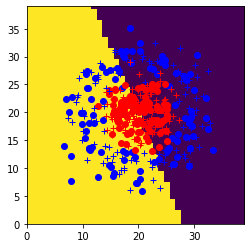

--> accuracy = 53.0


In [ ]:
from sklearn.svm import SVC, LinearSVC
# Noyau linéaire
svm = LinearSVC()
svm.fit(Xtrain, Ytrain)
front = svm.predict(Xgrid)
plot_svm_predictions(data,front)
Ypred = svm.predict(Xtest)
acc = np.sum(Ypred == Ytest)*100 / Ytest.size 
print(f'--> accuracy = {acc}')

###########################

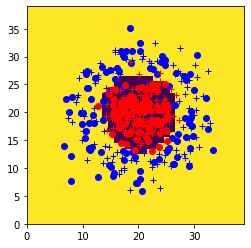

--> accuracy = 94.0


In [25]:
# Noyau gaussien
svm = SVC(kernel='rbf')
svm.fit(Xtrain, Ytrain)
front = svm.predict(Xgrid)
plot_svm_predictions(data,front)
Ypred = svm.predict(Xtest)
acc = np.sum(Ypred == Ytest)*100 / Ytest.size 
print(f'--> accuracy = {acc}')

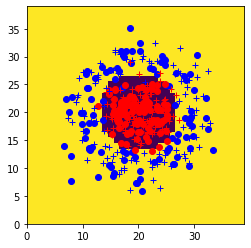

--> accuracy = 95.5


In [ ]:
# Noyau polynomial
svm = SVC(kernel='poly',degree=2)
svm.fit(Xtrain, Ytrain)
front = svm.predict(Xgrid)
plot_svm_predictions(data,front)
Ypred = svm.predict(Xtest)
acc = np.sum(Ypred == Ytest)*100 / Ytest.size 
print(f'--> accuracy = {acc}')

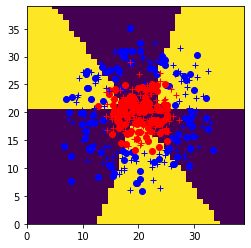

--> accuracy = 65.0


In [ ]:
# Noyau sigmoïde
svm = SVC(kernel='sigmoid')
svm.fit(Xtrain, Ytrain)
front = svm.predict(Xgrid)
plot_svm_predictions(data,front)
Ypred = svm.predict(Xtest)
acc = np.sum(Ypred == Ytest)*100 / Ytest.size 
print(f'--> accuracy = {acc}')

Training SVM with C=0.001
--> accuracy = 53.5
Training SVM with C=0.01
--> accuracy = 74.5
Training SVM with C=0.1
--> accuracy = 95.5
Training SVM with C=0.5
--> accuracy = 96.0
Training SVM with C=1
--> accuracy = 95.5
Training SVM with C=5
--> accuracy = 95.0
Training SVM with C=10
--> accuracy = 94.5
Training SVM with C=15
--> accuracy = 93.5


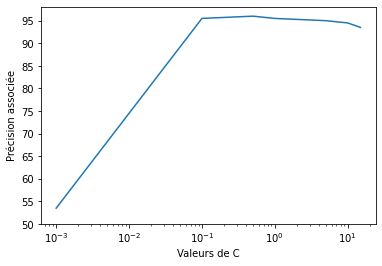

In [ ]:
# Reprise du code du TME 2-bis.
C_values = [0.001, 0.01, 0.1, 0.5, 1,5,10,15]
accuracies = []
for c in C_values:
  print(f'Training SVM with C={c}')
  # Create a svm Classifier
  clf = SVC(C=c, kernel='poly', degree=2) # Polynomial kernel
  # Fit on sub-train set
  clf.fit(Xtrain, Ytrain) # Train the model using the training sets
  # Evaluate on val set
  Ypred = clf.predict(Xtest) # Predict the response for validate dataset
  acc = np.sum(Ypred == Ytest)*100 / Ytest.size 
  accuracies.append(acc)
  print(f'--> accuracy = {acc}')

plt.plot(C_values,accuracies)
plt.xlabel('Valeurs de C')
plt.ylabel('Précision associée')
plt.xscale('log')
plt.yticks(np.arange(50,100,5))
#plt.xticks(np.arange(len(C_values)),C_values)
plt.show()